## Imports

In [176]:
import glob
import os
import cv2
import random
import torch
import torchvision

import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from typing import Tuple
from torch.utils.data import Dataset, DataLoader
from typing import Any
from torchvision.transforms import v2

In [155]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"  # A fix for some strange matplotlib error

## Set seed

In [156]:
seed = 23

In [157]:
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

## Load data

In [158]:
def load_data(dataset_folder_path: str) -> Tuple[pd.DataFrame, torch.tensor]:
    """
    Returns pd.Dataframe with targets and torch.tensor with photo data
    """
    df = None
    photos = []
    curr_photo_id = 0
    for csv_file in glob.glob(f"{dataset_folder_path}/*.csv"):
        folder_df = pd.read_csv(
            csv_file, header=None, names=["filename", "forward", "left"]
        )
        photo_folder_name = os.path.splitext(csv_file)[0]
        folder_df["folder_name"] = photo_folder_name
        photo_paths = glob.glob(f"{photo_folder_name}/*.jpg")
        for photo_path in photo_paths:
            photos.append(torchvision.io.read_image(photo_path))
        folder_df["photo_id"] = folder_df.index + curr_photo_id
        curr_photo_id += folder_df.index.max() + 1
        if df is None:
            df = folder_df
        else:
            df = pd.concat([df, folder_df], axis=0)
    df = df.set_index("photo_id")
    photos = torch.from_numpy(np.array(photos))
    return df, photos


df, photos = load_data("dataset")
df

,filename,forward,left,folder_name
photo_id,,,,
0,24,0.039062,0.000000,dataset\1652875851.3497071
1,25,0.210938,0.000000,dataset\1652875851.3497071
2,26,0.390625,0.000000,dataset\1652875851.3497071
3,27,0.421875,0.000000,dataset\1652875851.3497071
4,28,0.421875,0.000000,dataset\1652875851.3497071
...,...,...,...,...
7579,113,0.398438,0.992188,dataset\1653043549.5187616
7580,114,0.367188,0.992188,dataset\1653043549.5187616
7581,115,0.367188,0.992188,dataset\1653043549.5187616


## Dataset

In [159]:
class JetbotDataset(Dataset):
    def __init__(
        self, df: pd.DataFrame, images: torch.tensor, transforms: list = []
    ) -> None:
        """
        df: pd.DataFrame loaded by load_data()
        images: torch.tensor with image data loaded by load_data()
        transforms: a list of transforms to augment the data with
        """
        super().__init__()
        self.df = df
        self.images = images
        self.transforms = transforms

    def __len__(self) -> int:
        return self.df.shape[0]

    def __getitem__(self, index) -> Tuple[np.array, np.array]:
        sample = self.df.iloc[index]
        target = torch.tensor([sample.forward, sample.left])
        img = self.images[index]
        if len(self.transforms) > 0:
            random_transform = np.random.choice(self.transforms)
            img, target = random_transform(img, target)
        return img, target

In [165]:
def display_image(img: torch.tensor, target: torch.tensor = None):
    plt.imshow(img.numpy().transpose((1, 2, 0)))
    if target is not None:
        plt.text(
            0,
            -10,
            f'Target: [{",".join([str(i) for i in target])}]',
            fontsize="x-large",
        )

## Transforms

In [166]:
class RandomJetbotHorizontalFlip(torch.nn.Module):
    def __init__(self, p: float = 0.5) -> None:
        super().__init__()
        self.p = p

    def forward(self, *inputs: Any) -> Any:
        img, target = inputs
        if np.random.random() >= self.p:  # Flip
            img = torchvision.transforms.functional.hflip(img)
            target[1] *= -1  # Flip 'left' component
        return img, target


# Vertical flip doesn't make sense in our problem

train_transforms = [RandomJetbotHorizontalFlip()]  # Feel free to add more
test_transforms = []  # Test on original examples

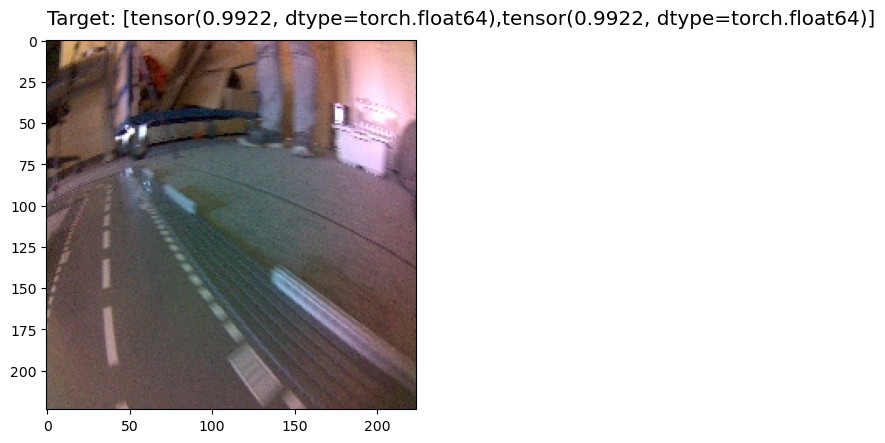

In [173]:
dataset = JetbotDataset(df, photos, train_transforms)
img, target = dataset[400]
display_image(img, target)

## Train-test-validation split

In [180]:
train_size = 0.7
val_size = 0.15
test_size = 1 - (train_size + val_size)
batch_size = 64

data_indices = np.random.permutation(np.arange(df.shape[0]))

train_end_index = int(len(data_indices) * train_size)
val_end_index = train_end_index + int(len(data_indices) * val_size)

train_dataloader = DataLoader(
    JetbotDataset(
        df.iloc[data_indices[:train_end_index]], photos[data_indices[:train_end_index]]
    ),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    JetbotDataset(
        df.iloc[data_indices[train_end_index:val_end_index]],
        photos[data_indices[train_end_index:val_end_index]],
    ),
    batch_size=batch_size
)

test_dataloader = DataLoader(
    JetbotDataset(
        df.iloc[data_indices[val_end_index:]],
        photos[data_indices[val_end_index:]],
    ),
    batch_size=batch_size
)

## Training

In [ ]:
def train_model(model: nn.Module, epochs: int, trainloader: DataLoader, validloader: DataLoader, optimizer: torch.optim.Optimizer, loss_func: callable):
    """
        Taken from https://www.geeksforgeeks.org/training-neural-networks-with-validation-using-pytorch/,
        feel free to change it
    """
    for e in range(epochs):
        train_loss = 0.0
        model.train()     # Optional when not using Model Specific layer
        for data, labels in trainloader:
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()
            
            optimizer.zero_grad()
            target = model(data)
            loss = loss_func(target,labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        valid_loss = 0.0
        model.eval()     # Optional when not using Model Specific layer
        for data, labels in validloader:
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()
            
            target = model(data)
            loss = loss_func(target,labels)
            valid_loss = loss.item() * data.size(0)

        print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(trainloader)} \t\t Validation Loss: {valid_loss / len(validloader)}')
        if min_valid_loss > valid_loss:
            print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
            min_valid_loss = valid_loss
            # Saving State Dict
            torch.save(model.state_dict(), 'saved_model.pth')